In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys

import sys
sys.path.insert(0, '/usr/src/app/src')
import test
import background as bg

mpl.rcParams['figure.figsize'] = (10,10)
plt.rcParams['figure.dpi'] = 150

ModuleNotFoundError: No module named 'custom_detector'

In [3]:
img, _ = test.sample_frames(start=4960)
H, W = img.shape[:2]

worker = bg.BackgroundTracker()
kps = worker.keypoints(img)
print(len(kps))

44


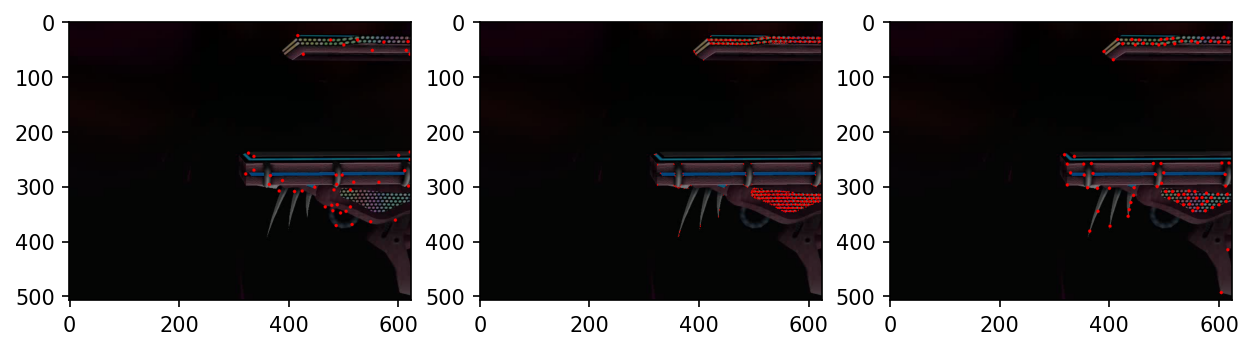

In [4]:
marked = (img.copy() * 0.5).astype(np.uint8)
for kp in kps:
    x, y = kp.pt
    x, y = int(x), int(y)
    cv.circle(marked, (x,y), radius=3, color=(255,0,0), thickness=-1)

gray = bg.grayscale(img)
dst = cv.cornerHarris(gray, 2,3,0.04)
marked2 = (img.copy() * 0.5).astype(np.uint8)
marked2[dst>0.01*dst.max()] = (255,0,0)

corners = cv.goodFeaturesToTrack(gray, 80, 0.01, 10)
corners = np.int0(corners)
marked3 = (img.copy() * 0.5).astype(np.uint8)
for i in corners:
    x,y = i.ravel()
    cv.circle(marked3, (x,y), 3, (255,0,0), -1)

plt.subplot(131)
plt.imshow(marked)
plt.subplot(132)
plt.imshow(marked2)
plt.subplot(133)
plt.imshow(marked3)
plt.show()

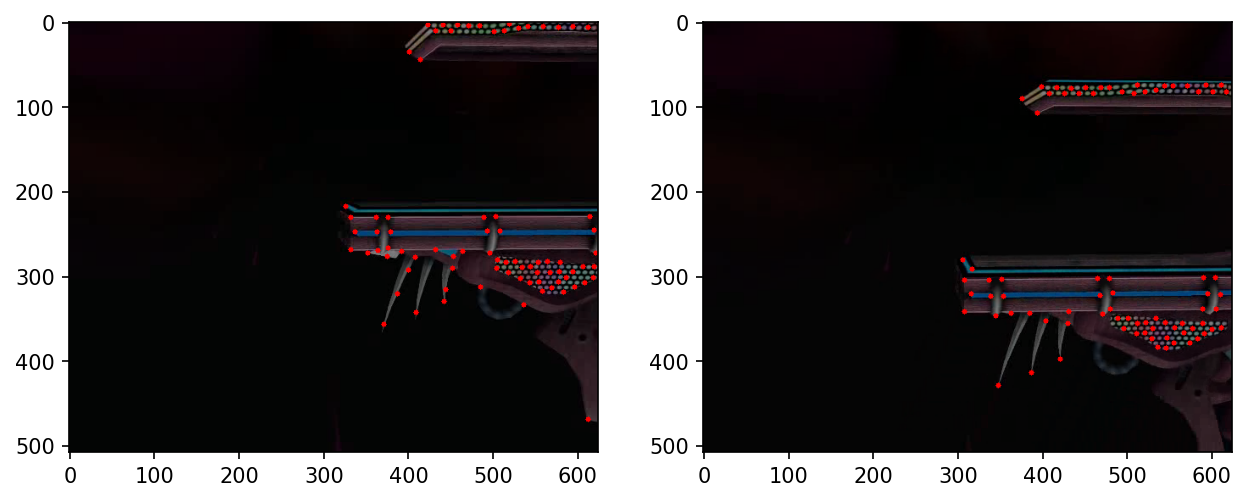

In [5]:
frame1, frame2 = test.sample_frames(start=4960, gap=5)

worker = bg.BackgroundTracker(patch_size=48)
kps1 = worker.keypoints(frame1, method='shi_tomasi', num_pts=80)
kps2 = worker.keypoints(frame2, method='shi_tomasi', num_pts=80)

marked1 = (frame1.copy() * 0.5).astype(np.uint8)
for kp in kps1:
    x,y = kp.pt
    x,y = int(x), int(y)
    cv.circle(marked1, (x,y), 3, (255,0,0), -1)
    
marked2 = (frame2.copy() * 0.5).astype(np.uint8)
for kp in kps2:
    x,y = kp.pt
    x,y = int(x), int(y)
    cv.circle(marked2, (x,y), 3, (255,0,0), -1)
    
ax = plt.subplot(121)
ax.imshow(marked1)
ax = plt.subplot(122)
ax.imshow(marked2)
plt.show()

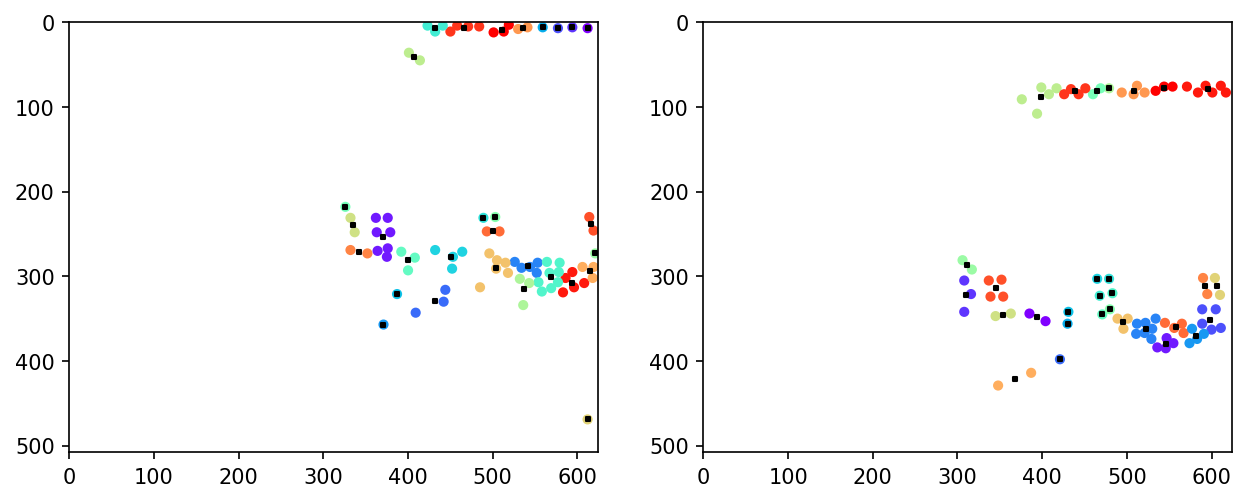

In [6]:
kps_per_imgs = [kps1, kps2]

num_clusters = 30
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
colors = mpl.cm.rainbow(np.linspace(0, 1, num_clusters))
num_plots = len(kps_per_imgs)

clusters_per_imgs = []
cluster_cntrs_per_imgs = []
for plot_num, kps in enumerate(kps_per_imgs):
    pts = np.float32([kp.pt for kp in kps])
    retval,labels,centers=cv.kmeans(data=pts, 
                                    K=num_clusters,
                                    bestLabels=None,
                                    criteria=criteria,
                                    attempts=40,
                                    flags=cv.KMEANS_RANDOM_CENTERS)
    clusters = [[] for _ in range(num_clusters)]
    for i, cluster_group in enumerate(labels):
        clusters[cluster_group[0]].append(pts[i])

    clusters_per_imgs.append(clusters)
    cluster_cntrs_per_imgs.append(centers)

    x, y = zip(*pts)
    x0, y0 = zip(*centers)
    
    colors_per_pt = [colors[i[0]] for i in labels]
    
    ax = plt.subplot(1, num_plots, plot_num+1)
    ax.set_aspect('equal')
    ax.set_xlim((0,W))
    ax.set_ylim((H,0))
    ax.scatter(x , y , s=15, c=colors_per_pt)
    ax.scatter(x0, y0, s=5 , c='black', marker='s')
    
plt.show()

In [7]:
tracker = bg.BackgroundTracker()

def cluster_descriptor(pts_from_clstr, img):
    kps = [cv.KeyPoint(x=x,y=y,_size=0) for x,y in pts_from_clstr]
    palettes = tracker.color_descriptors(kps, img)
    total_palette = {}
    for p in palettes:
        for color, freq in p.items():
            if color not in total_palette:
                total_palette[color] = freq
            else:
                total_palette[color] += freq
    return total_palette
    
clusters1, clusters2 = clusters_per_imgs
ctrs1, ctrs2 = cluster_cntrs_per_imgs
des1 = [cluster_descriptor(c, frame1) for c in clusters1]
des2 = [cluster_descriptor(c, frame2) for c in clusters2]

print(len(des1))
for palette in des1:
    print(len(palette.keys()))

all_match_sets = bg.match(des1, des2, key=bg.compare_palettes)
refined_match_results = bg.reduce_repeated_matches(all_match_sets)

top_matches = []
for ordered_matches in refined_match_results:
    top_match = ordered_matches[0]
    print(top_match)
    top_matches.append(top_match['index'])

30
11
31
11
17
11
26
6
11
9
26
23
19
25
25
21
22
8
25
14
26
7
30
19
15
28
25
18
16
21
16
{'index': 6, 'score': 0.3611354698129251}
{'index': 27, 'score': 0.276491195436508}
{'index': 18, 'score': 0.43515625}
{'index': 7, 'score': 0.3916967828798186}
{'index': 8, 'score': 0.7296006944444444}
{'index': 23, 'score': 0.22593315972222205}
{'index': 13, 'score': 0.8233506944444444}
{'index': 11, 'score': 0.6085069444444444}
{'index': 15, 'score': 0.6888020833333334}
{'index': 4, 'score': 0.7511935763888888}
{'index': 1, 'score': 0.27756076388888895}
{'index': 24, 'score': 0.4268663194444444}
{'index': 19, 'score': 0.18777126736111127}
{'index': 14, 'score': 0.2662760416666665}
{'index': 21, 'score': 0.5883969907407407}
{'index': 29, 'score': 0.20572916666666663}
{'index': 16, 'score': 0.515842013888889}
{'index': 28, 'score': 0.1190656565656566}
{'index': 12, 'score': 0.4676649305555556}
{'index': 3, 'score': 0.23769959895679527}
{'index': 20, 'score': 0.44685635719612216}
{'index': 17, 'sco

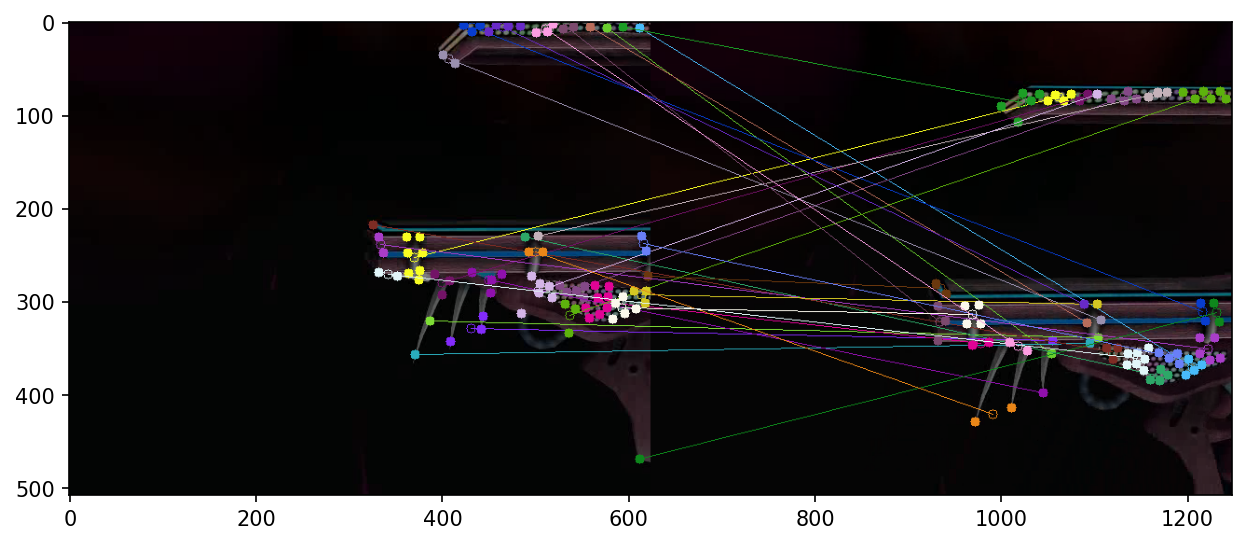

In [8]:
def rnd_color():
    return [np.random.random() * 255 for _ in range(3)]

H, W = frame1.shape[:2]
combined = (np.hstack((frame1, frame2)) * 0.5).astype(np.uint8)
for i, match in enumerate(top_matches):
    x0, y0 = ctrs1[i]
    x1, y1 = ctrs2[match]
    pt1 = (int(x0)    , int(y0))
    pt2 = (int(x1) + W, int(y1))
    
    color = rnd_color()
    
    for pt in clusters1[i]:
        x, y = pt
        x, y = int(x), int(y)
        combined = cv.circle(combined, (x,y), 5, color, -1)
    
    for pt in clusters2[match]:
        x, y = pt
        x, y = int(x), int(y)
        combined = cv.circle(combined, (x+W, y), 5 , color, -1)
    
    combined = cv.circle(combined, pt1, 5, color)
    combined = cv.circle(combined, pt2, 5, color)
    combined = cv.line(combined, pt1, pt2, color, 1)
plt.imshow(combined)
plt.show()

[(-1.9, -0.7568024953079282), (-0.9, 0.8414709848078965), (0.1, 0.0), (1.1, 0.8414709848078965), (2.1, -0.7568024953079282), (3.1, 0.4121184852417566), (4.1, -0.2879033166650653)] [(-3, 0.4121184852417566), (-2, -0.7568024953079282), (-1, 0.8414709848078965), (0, 0.0), (1, 0.8414709848078965), (2, -0.7568024953079282), (3, 0.4121184852417566)]
{'index': 1, 'score': -0.10000000000000009}
{'index': 2, 'score': -0.09999999999999998}
{'index': 3, 'score': -0.1}
{'index': 4, 'score': -0.10000000000000009}
{'index': 5, 'score': -0.10000000000000009}
{'index': 6, 'score': -0.10000000000000009}
{'index': 6, 'score': -1.3038521860797232}

{'index': 1, 'score': -0.10000000000000009}
{'index': 2, 'score': -0.09999999999999998}
{'index': 3, 'score': -0.1}
{'index': 4, 'score': -0.10000000000000009}
{'index': 5, 'score': -0.10000000000000009}
{'index': 6, 'score': -0.10000000000000009}
{'index': 0, 'score': -7.134425731840291}
-7.734425731840291
-11.164414195337638
8.40002180190682
15.6173526928536

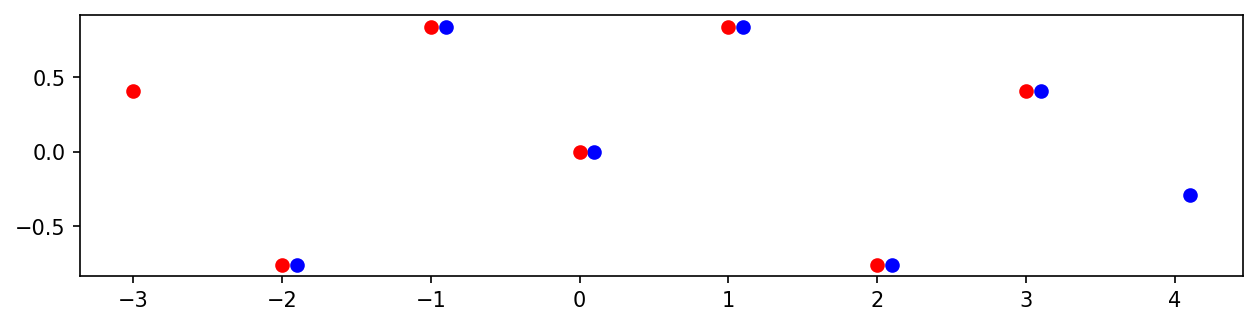

In [12]:
def cluster_matching_v2():
    pass

def compare_clusters(c1, c2):
    pass

def match_pts(pts1, pts2):
    match_results = bg.match(pts1, pts2, key=compare_pts)
    for ordered_matches in match_results:
        print(ordered_matches[0])
        
    print()
    unique_match_results = bg.reduce_repeated_matches(match_results)
    sum_dists = 0
    for ordered_matches in unique_match_results:
        print(ordered_matches[0])
        sum_dists += ordered_matches[0]['score']
    print(sum_dists)
    
    sum2 = sum((compare_pts(p1, p2) for p1, p2 in zip(pts1, pts2)))
    print(sum2)
    
    matched = []
    for i, i2 in enumerate((matches[0]['index'] for matches in unique_match_results)):
        matched.append((pts1[i], pts2[i2]))
    return matched


def compare_pts(p1, p2):
    x0, y0 = p1
    x1, y1 = p2
    dx = x1 - x0
    dy = y1 - y0
    dist = np.sqrt(dx ** 2 + dy ** 2)
    return -1 * dist

def compare_pts_v2(p1, p2):
    x0, y0 = p1
    x1, y1 = p2
    dx = x1 - x0
    dy = y1 - y0
    return abs(dx) + abs(dy)

def match_result_score(matches):
    scores = (compare_pts_v2(p1, p2) for p1, p2 in matches)
    return sum(scores)

pts1 = [(x+0.1, np.sin(x**2) ) for x in range(-2,5)]
pts2 = [(x, np.sin(x**2) ) for x in range(-3,4)]
print(pts1, pts2)
matches = match_pts(pts1, pts2)
matches2 = [(pts1[i], pts2[i]) for i in range(len(matches))]

print(match_result_score(matches))
print(match_result_score(matches2))

x0, y0 = zip(*pts1)
x1, y1 = zip(*pts2)
ax = plt.subplot(111)
plt.scatter(x0, y0, c='b')
plt.scatter(x1, y1, c='r')
ax.set_aspect('equal')
plt.show()

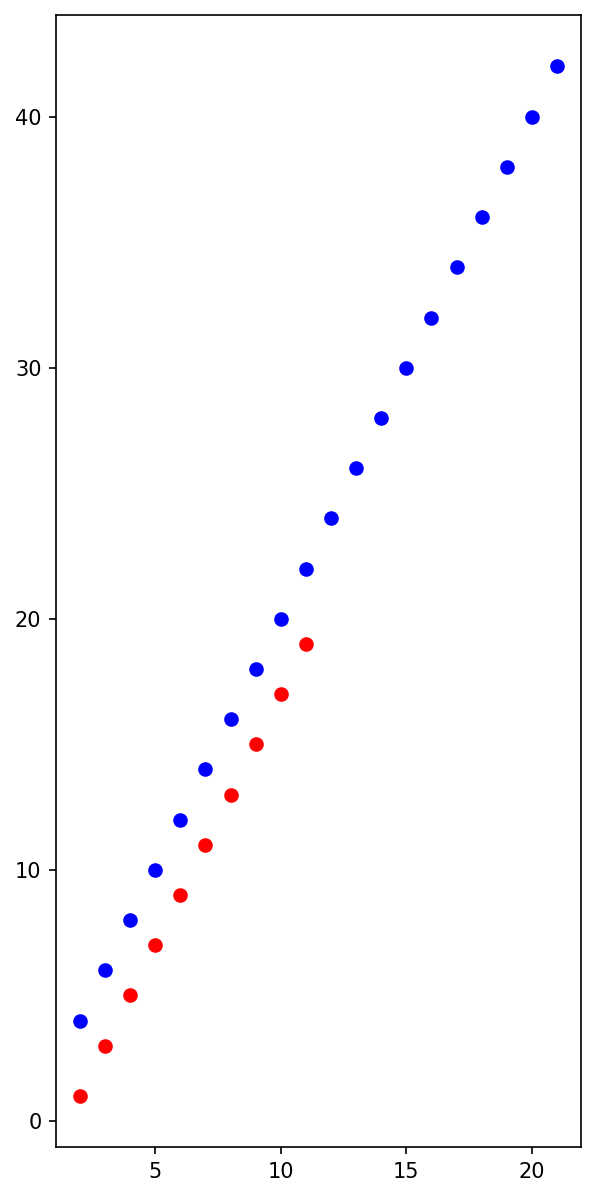

{'index': 9, 'score': -25.079872407968907}
{'index': 9, 'score': -22.847319317591726}
{'index': 9, 'score': -20.615528128088304}
{'index': 9, 'score': -18.384776310850235}
{'index': 9, 'score': -16.15549442140351}
{'index': 9, 'score': -13.92838827718412}
{'index': 9, 'score': -11.704699910719626}
{'index': 9, 'score': -9.486832980505138}
{'index': 9, 'score': -7.280109889280518}
{'index': 9, 'score': -5.0990195135927845}
{'index': 9, 'score': -3.0}
{'index': 9, 'score': -1.4142135623730951}
{'index': 8, 'score': -1.4142135623730951}
{'index': 7, 'score': -1.4142135623730951}
{'index': 6, 'score': -1.4142135623730951}
{'index': 5, 'score': -1.4142135623730951}
{'index': 4, 'score': -1.4142135623730951}
{'index': 3, 'score': -1.4142135623730951}
{'index': 2, 'score': -1.4142135623730951}
{'index': 1, 'score': -1.4142135623730951}

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
{'index': 0, 'score': -22.847319317591726}
{'index': 9, 'score': -1.4142135623730951}
{'index': 8, 'score': -1.4142135623730951}

In [28]:
pts1 = [(x,2*x) for x in range(21, 1, -1)]
pts2 = [(x+1, 2*x-1) for x in range(1, 11)]

x0, y0 = zip(*pts1)
x1, y1 = zip(*pts2)
ax = plt.subplot(111)
plt.scatter(x0, y0, c='b')
plt.scatter(x1, y1, c='r')
ax.set_aspect('equal')
plt.show()

match_results = bg.match(pts1, pts2, key=compare_pts)
for ordered_matches in match_results:
    print(ordered_matches[0])
    
print()
unique_results = bg.reduce_repeated_matches(match_results)
for ordered_matches in unique_results:
    print(ordered_matches[0] if len(ordered_matches) > 0 else ordered_matches)

In [32]:
sift = cv.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(frame1,None)
kp2, des2 = sift.detectAndCompute(frame2,None)
for descriptor in des1:
    print(descriptor)

[ 92 177 188 167 141  92  20 133 234  21 143   8 150 181  72  58 128  86
 232  80  30  41 251  32 203 225  68  83 128  27 157 114]
[224  58 116 117  52 143 161  19 118 225 230 124 161  17  22 212  93 172
  41 152 171 250 209 159  78 255 147  50   7 128  82  40]
[213 231  11 101 184  75 238 248  22 226 170 203 209 255 233  33 187  77
 106 238 100 211 169  63 250 142  45  53   1 251  65 194]
[ 55  55 215 196 212  14  47 121  81 166 195 206  71  97  25 119  55 212
  91  98 181 211  61 136 122 118  69 148 142 235  54 132]
[ 73 160 215 117  11  78 112  19  54 189 242 199 155 191  64 138  86 188
 110  20  20 201 231   0  79 171 113 208 227 168  72  67]
[ 86  32  68  65  62 202 225  72  44  96 102  35 155  19 206   6  48  12
 125  60  19 208 129  68 156 232 131 198 109 132 115 177]
[ 66 161 172 110  41 217 192   9 175 181 173   8 230 234  88  54 136 176
 105  25  26   9 251  81 217 145 143 125 208   2  95  46]
[ 83 160 206  93  32 193 177  43  54 242 246  41 250 249 199   7 155 173
 127 172 1

0.29159432870370394
0.2737645759490416
0.6514105902777778
0.29710793733985563
0.18705721762279093
0.43732122425629283
0.22910090488215473
0.3839330357142856
0.6661241319444444
0.33044627786256
0.16291298400673426
0.3614320728291317


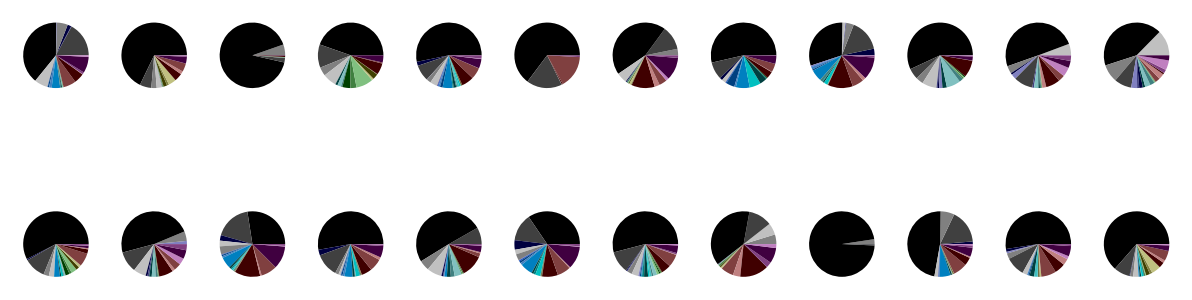

In [43]:
def palette_chart(p, plot):
    colors = [(r/255, g/255, b/255) for r,g,b in p.keys()]
    freqs = list(p.values())
    
#     colors.sort(key=lambda x:colorsys.rgb_to_hsv(*x)[0])

    hsvs = [{'color':colorsys.rgb_to_hsv(*c[::-1]),
             'pos':i}
            for i, c in enumerate(colors)]
    hsvs.sort(key=lambda x:x['color'][0])
    
    colors_sorted = []
    freqs_sorted = []
    for colorobj in hsvs:
        i = colorobj['pos']
        colors_sorted.append(colors[i])
        freqs_sorted.append(freqs[i])
    
    plot.pie(freqs_sorted, colors=colors_sorted)

    
fig, axes = plt.subplots(nrows=2, ncols=len(des1))
    
for i, palette in enumerate(des1):
    palette2 = des2[top_matches[i]]
    
    ax2 = axes[1,i]
    palette_chart(palette2, ax2)
    
    ax = axes[0,i]    
    palette_chart(palette, ax)
    
    print(bg.compare_palettes(palette, palette2))

plt.subplots_adjust(hspace=-0.8)
plt.show()

In [12]:
des1 = worker.color_descriptors(kps1, frame1)
des2 = worker.color_descriptors(kps2, frame2)

all_match_sets = bg.match(des1, des2, key=bg.compare_palettes)
refined_match_results = bg.reduce_repeated_matches(all_match_sets)

refined match still bad
0.21 94.0 2.0 0.1490461731979779
0.18 48.0 -62.0 0.08520247749688817
refined match still bad
refined match still bad
refined match still bad
refined match still bad
refined match still bad
refined match still bad
0.43 47.0 -86.0 0.08713936528265522
refined match still bad
refined match still bad
0.1 60.0 -40.0 0.10238051025009887
refined match still bad
refined match still bad
refined match still bad
0.33 26.0 9.0 0.04105117425230633
0.38 77.0 43.0 0.11493351089683544
refined match still bad
refined match still bad
refined match still bad
0.22 76.0 23.0 0.11692938845722799
refined match still bad
0.25 61.0 -66.0 0.10888661511549301
refined match still bad
refined match still bad
refined match still bad
refined match still bad
refined match still bad
0.42 72.0 -125.0 0.14329957822872083
0.3 65.0 139.0 0.08498484762854042
refined match still bad
refined match still bad
0.39 71.0 -98.0 0.1341700567797797
0.28 59.0 24.0 0.0907990273139421
refined match still bad
ref

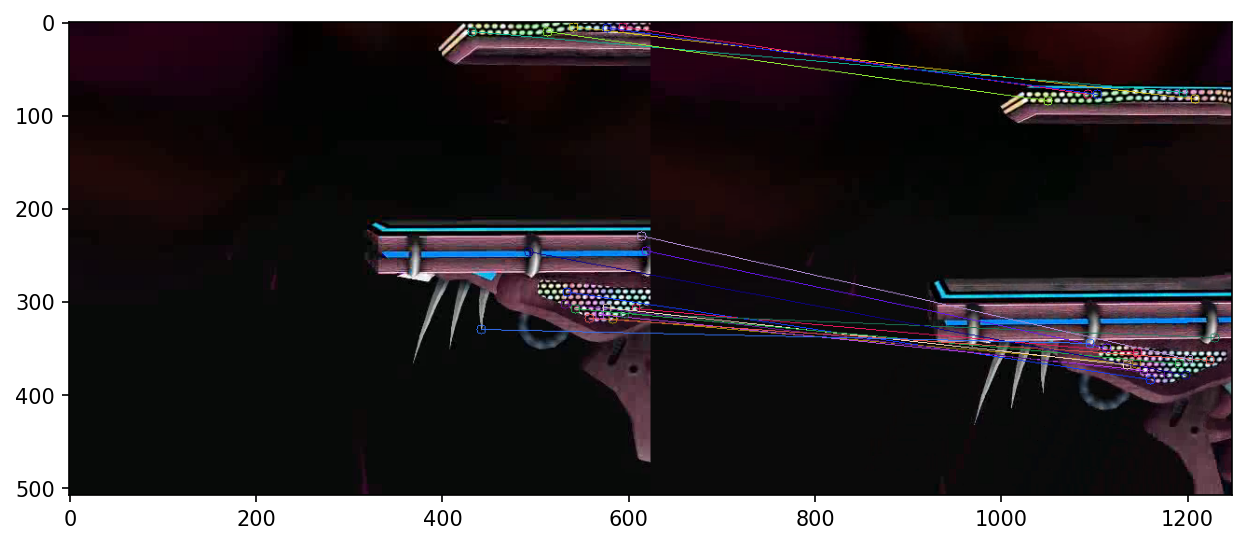

In [13]:
def slope(dy, dx):
    return dy / dx if not dx == 0 else 1000    # arbitrary big represent vertical slope

scores = []
xdiffs = []
ydiffs = []
angles = []
valid_pairs = []

H, W = frame1.shape[:2]
combined = np.hstack((frame1, frame2))
for i, ordered_matches in enumerate(refined_match_results):
    
    j = ordered_matches[0]['index']
    score = ordered_matches[0]['score']
    
    kp1 = kps1[i]
    kp2 = kps2[j]
    x0, y0 = kp1.pt
    x1, y1 = kp2.pt
    dy = (y1 - y0)
    dx = (x1 - x0)
    m = slope(dy, dx + W)
    angle = np.arctan(m)
    
    qualifies = (
        abs(dx) < 150 and 
        abs(dy) < 150)# and 
        #score < 0.5)# and
        #abs(angle + 0.027302902479401158) < 0.1264880947869528)# and  
        
    if not qualifies:
        print('refined match still bad')
        continue
        
    print(round(score, 2), dy, dx, angle)
    
    valid_pairs.append((kp1, kp2))
    
    scores.append(score)
    ydiffs.append(dy)
    xdiffs.append(dx)
    angles.append(angle)

    pt1 = (int(x0)    , int(y0))
    pt2 = (int(x1) + W, int(y1))
    color = rnd_color()
    combined = cv.circle(combined, pt1, 5, color)
    combined = cv.circle(combined, pt2, 5, color)
    combined = cv.line(combined, pt1, pt2, color, 1)

plt.imshow(combined)
plt.show()

In [14]:
len(valid_pairs), len(refined_match_results)

(18, 60)

In [15]:
sum(xdiffs) / len(xdiffs), sum(ydiffs) / len(ydiffs), slope(sum(ydiffs), sum(xdiffs))

(-18.833333333333332, 69.88888888888889, -3.7109144542772863)

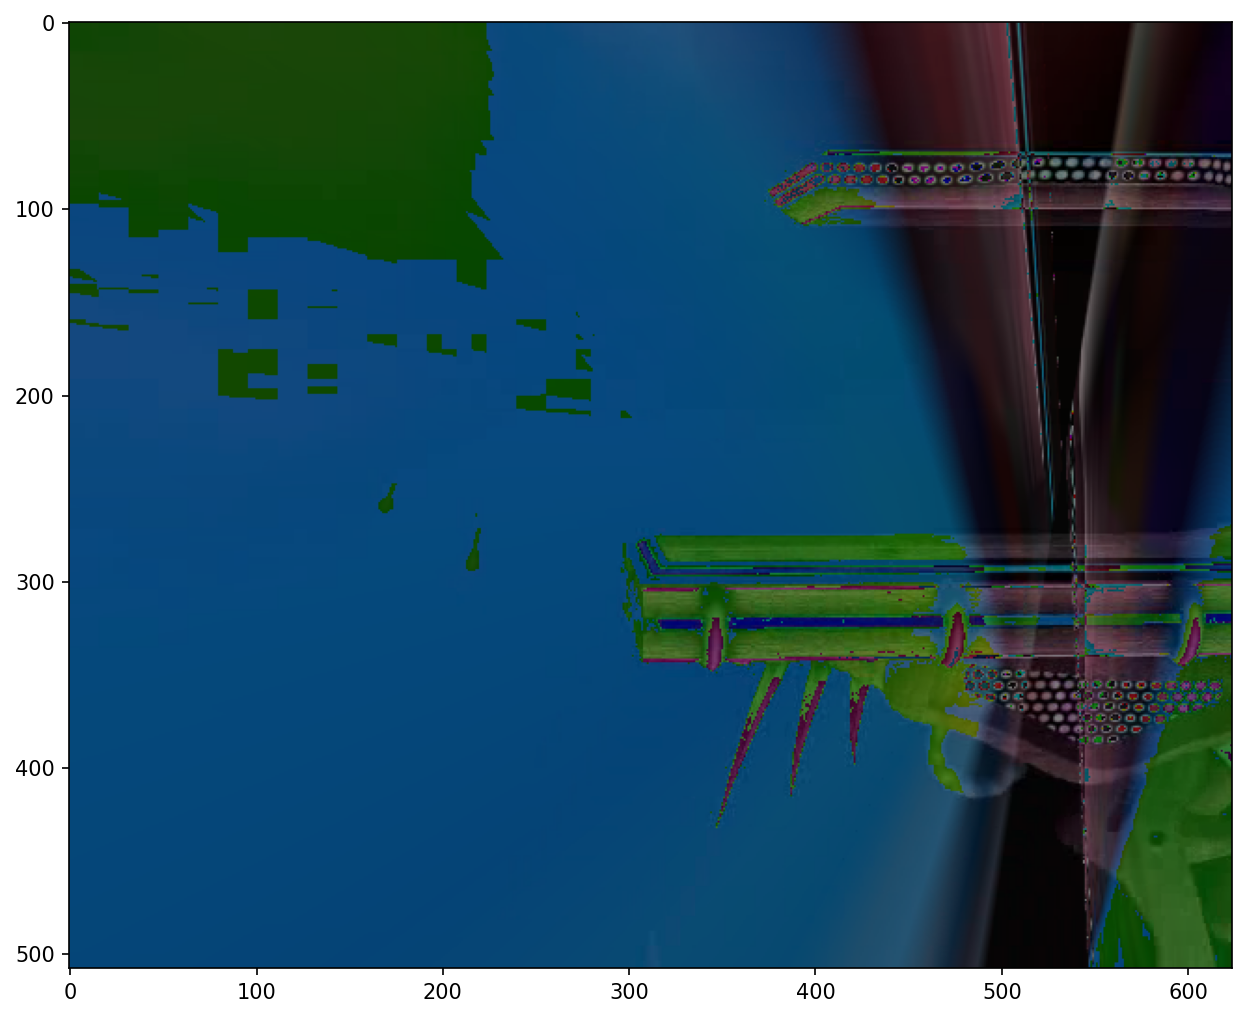

In [16]:
pts1 = np.array([kp1.pt for (kp1, kp2) in valid_pairs])
pts2 = np.array([kp2.pt for (kp1, kp2) in valid_pairs])

h, status = cv.findHomography(pts1, pts2)

warped = cv.warpPerspective(frame1, h, (W, H))

averaged = (warped + frame2) * 0.5
averaged = averaged.astype(np.uint8)

plt.imshow(averaged)
plt.show()

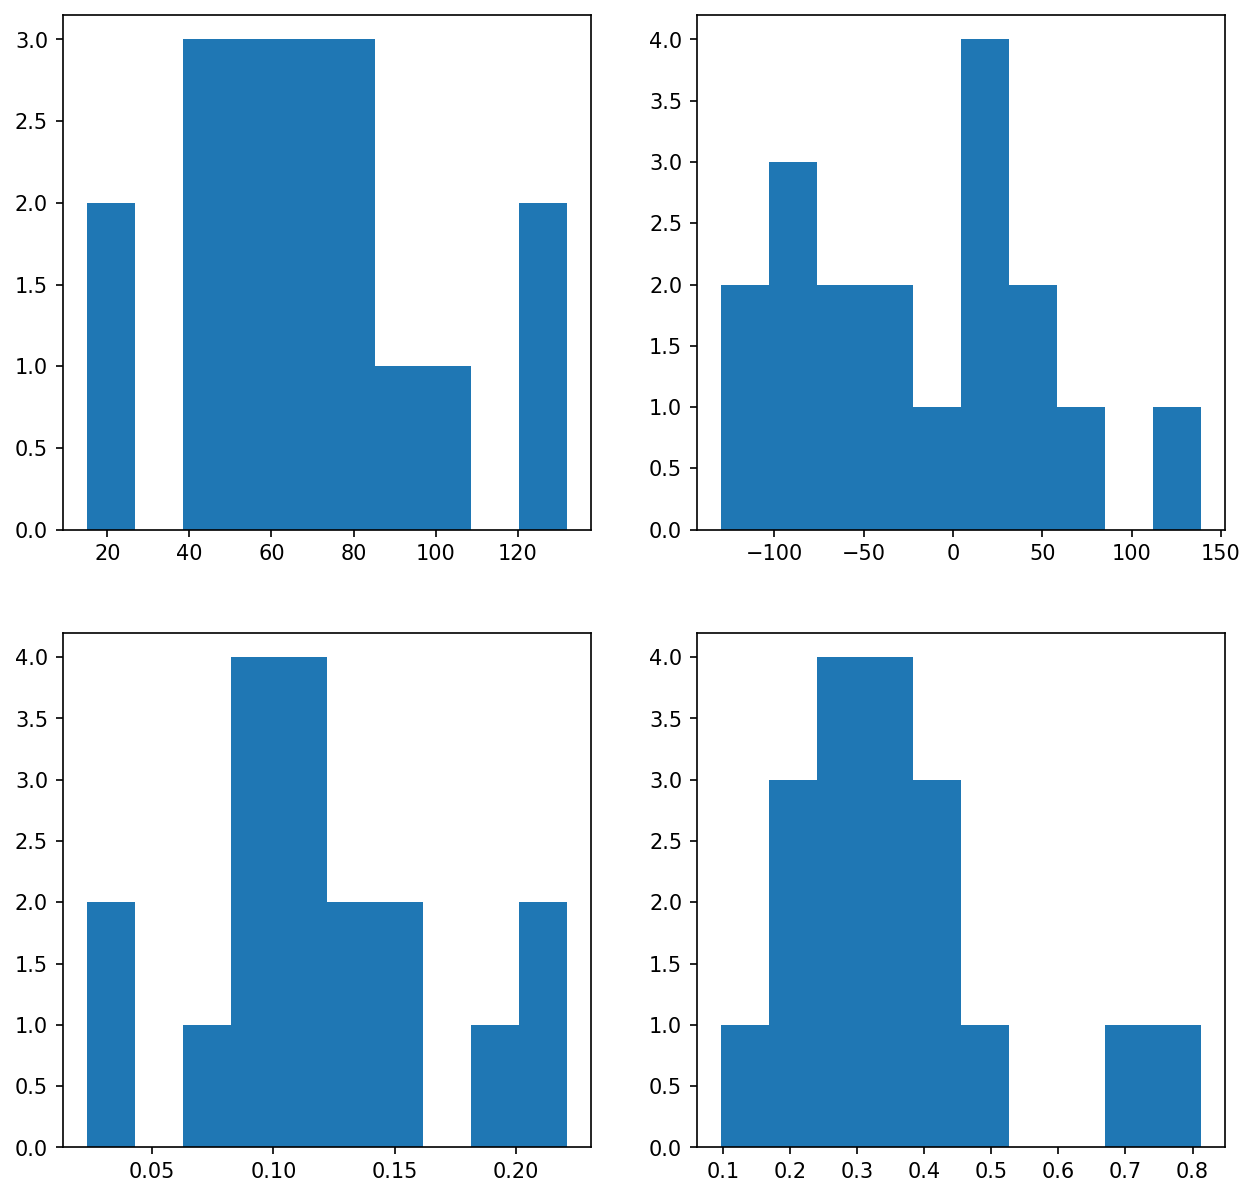

In [17]:
plt.subplot(221)
plt.hist(ydiffs)
plt.subplot(222)
plt.hist(xdiffs)
plt.subplot(223)
plt.hist(angles)
plt.subplot(224)
plt.hist(scores)
plt.show()

In [19]:
np.mean(angles), np.median(angles), np.std(angles) 

(0.11666526793243029, 0.11191006300616423, 0.05112801355522962)